<h3 align="center"><font size="15">Projet 5 : Classifiez automatiquement des biens de consommation</font></h3>

<h3 align="center"><font size="6.5">CNN</font></h3>

* [Chapitre 1 : Algorithme de type CNN](#chapter1)
    * [Importation des données et des librairies](#section_1_1)
    * [Extractions des variables](#section_1_2)
    * [Validation du modèle](#section_1_3)
        * [Visualisation t-SNE](#section_1_3_1)
        * [Matrice de confusion](#section_1_3_2)
    * [Données mixte](#section_1_4)
        * [USE et CNN](#section_1_4_1)
            * [Préparation du jeu de données](#section_1_4_1_1)
            * [Visualisation t-SNE](#section_1_4_1_2)
            * [Matrice de confusion](#section_1_4_1_3)    
        * [TF-IDF et CNN](#section_1_4_2)
            * [Préparation du jeu de données](#section_1_4_2_1)
            * [Visualisation t-SNE](#section_1_4_2_2)
            * [Matrice de confusion](#section_1_4_2_3)            
       
* [Chapitre 2 : Création de nouveaux modèles](#chapter2)
    * [Création des modèles](#section_2_1)
        * [Modèle test 1](#section_2_1_1)
        * [Modèle test 2](#section_2_1_2)
    * [Jeu de données](#section_2_2)
        * [Séparation des données](#section_2_2_1)
        * [Création des données d'entraînement et de validation](#section_2_2_2)
    * [Entraînement du modèle test 1](#section_2_3)
        * [Entraînement](#section_2_3_1)
        * [Fonction coût et score](#section_2_3_2)
        * [Matrice de confusion](#section_2_3_3)
    * [Entraînement du modèle test 2](#section_2_4)
        * [Entraînement](#section_2_4_1)
        * [Fonction coût et score](#section_2_4_2)
        * [Matrice de confusion](#section_2_4_3)

<a class="anchor" id="chapter1"></a>
# Chapitre 1 : Algorithme de type CNN

<a class="anchor" id="section_1_1"></a>
## Importation des données et des librairies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import scipy.stats as st
import random
import itertools
import datetime
import time
import statsmodels.api as sm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import cluster, metrics, manifold, decomposition, preprocessing, manifold, model_selection
from sklearn.cluster import KMeans, MiniBatchKMeans
from scipy.optimize import linear_sum_assignment
from matplotlib.collections import LineCollection
from matplotlib import colors
from matplotlib.lines import Line2D
from itertools import chain
from keras.models import Model

from PIL import Image, ImageOps 
from skimage.feature import hog, ORB, match_descriptors
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

data = pd.read_csv("data_projet_6.csv", low_memory=False, index_col=0)

<a class="anchor" id="section_1_2"></a>
## Extractions des variables

In [2]:
path = 'C:/Users/farid/Anaconda/Notebook/Dataset_p6/'

img_test = Image.open(path + data.iloc[1]["image"])

# img_test.show()

w, h = img_test.size
print("Largeur : {} px, hauteur : {} px".format(w, h))

Largeur : 856 px, hauteur : 1100 px


In [3]:
img = Image.open(path + data.iloc[1]["image"])  # Charger l'image
img = img.resize((224,224))
img_array = np.array(img)
img_test = img_array.reshape((1, 
                              img_array.shape[0], 
                              img_array.shape[1], 
                              img_array.shape[2]))  # Créer la collection d'images (un seul échantillon)
img_test = preprocess_input(img_test)  # Prétraiter l'image comme le veut VGG-16

In [4]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
y = model.predict(img_test)
y_0 = model.predict(img_test)[0]

1/1 [==============================] - 0s 164ms/step


In [6]:
display(y.shape)
display(y_0.shape)

(1, 4096)

(4096,)

In [7]:
features_cnn = []
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

for i in range(0, data.shape[0]):
    
    img = Image.open(path + data.iloc[i]["image"])
    img = img.resize((224,224))
    img_array = np.array(img)
    img_test = img_array.reshape((1, img_array.shape[0], img_array.shape[1], img_array.shape[2]))
    img_test = preprocess_input(img_test)
    
    features_cnn.append(model.predict(img_test)[0])

1/1 [==============================] - 0s 172ms/step


1/1 [==============================] - 0s 163ms/step


1/1 [==============================] - 0s 220ms/step


C:\Users\farid\Anaconda\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 [==============================] - 0s 372ms/step


<a class="anchor" id="section_1_3"></a>
## Validation du modèle

<a class="anchor" id="section_1_3_1"></a>
### Perplexité

In [8]:
import Fonction_P6 as p6

lab_category = data["category_label"].values
n_clusters = len(data["Main_category"].unique())

In [9]:
X_features_cnn = np.asarray(features_cnn)

display(X_features_cnn.shape)

(1050, 4096)

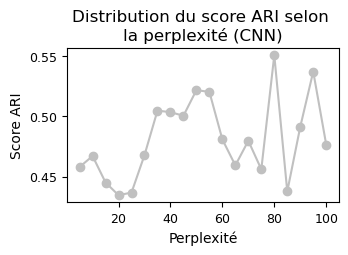

In [10]:
best_perp_cnn = p6.best_perplexity(lab_category, X_features_cnn, "CNN", 
                                   perp_min = 5, perp_max = 105, step = 5, n_clusters = 7)

<a class="anchor" id="section_1_3_2"></a>
### Matrice de confusion

Pour le modèle CNN, le score ARI est : 0.55049


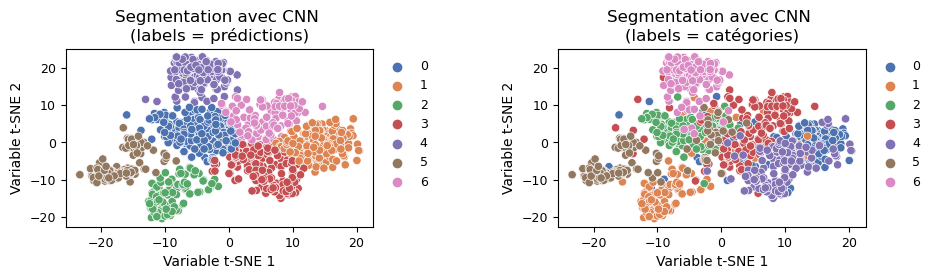

In [11]:
ARI_CNN, label_CNN = p6.graph_t_sne("CNN", best_perp_cnn, X_features_cnn, lab_category, n_clusters = 7)

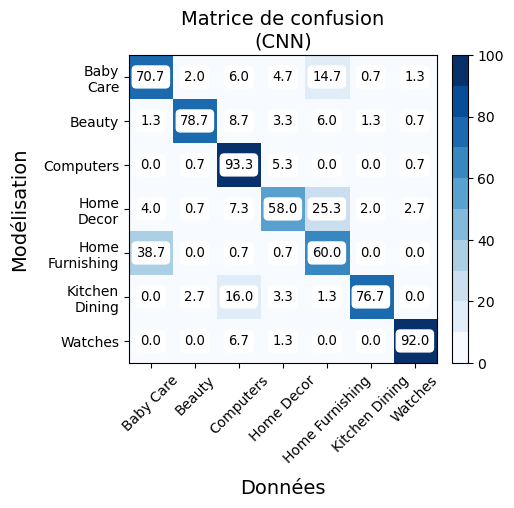

In [12]:
data["label_CNN"] = label_CNN

p6.graph_matrix(data["category_label"], data["label_CNN"], "CNN")

<a class="anchor" id="section_1_4"></a>
## Données mixte

<a class="anchor" id="section_1_4_1"></a>
### USE et CNN

<a class="anchor" id="section_1_4_1_1"></a>
#### Préparation du jeu de données

In [13]:
df_features_cnn = pd.merge(data[["image"]], pd.DataFrame(X_features_cnn), 
                           left_index=True, right_index=True, how="outer")

In [14]:
best_data_text_use = pd.read_csv("data_features_USE_projet_6.csv", low_memory=False, index_col=0)

display(best_data_text_use.shape)

In [15]:
best_data_text_use.iloc[:,:5].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1050 entries, 0 to 1049
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   1050 non-null   object 
 1   0       1050 non-null   float64
 2   1       1050 non-null   float64
 3   2       1050 non-null   float64
 4   3       1050 non-null   float64
dtypes: float64(4), object(1)
memory usage: 49.2+ KB


In [16]:
df_data_mixte_use = pd.merge(best_data_text_use, df_features_cnn, 
                             left_on="image", right_on="image", how="outer")
df_data_mixte_use.shape

(1050, 4609)

In [17]:
df_data_mixte_use.iloc[:,:5].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1050 entries, 0 to 1049
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   1050 non-null   object 
 1   0       1050 non-null   float64
 2   1       1050 non-null   float64
 3   2       1050 non-null   float64
 4   3       1050 non-null   float64
dtypes: float64(4), object(1)
memory usage: 49.2+ KB


In [18]:
X_mixte_use = df_data_mixte_use.iloc[:,1:].values

display((X_mixte_use.shape))

(1050, 4608)

<a class="anchor" id="section_1_4_1_2"></a>
#### Visualisation t-SNE

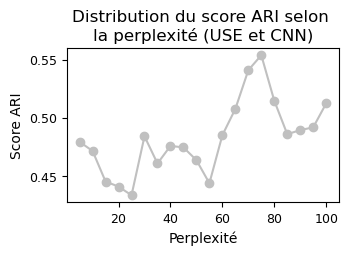

In [19]:
best_perp_mixte_use = p6.best_perplexity(lab_category, X_mixte_use, "USE et CNN", 
                                         perp_min = 5, perp_max = 105, step = 5, n_clusters = 7)

Pour le modèle USE et CNN, le score ARI est : 0.55369


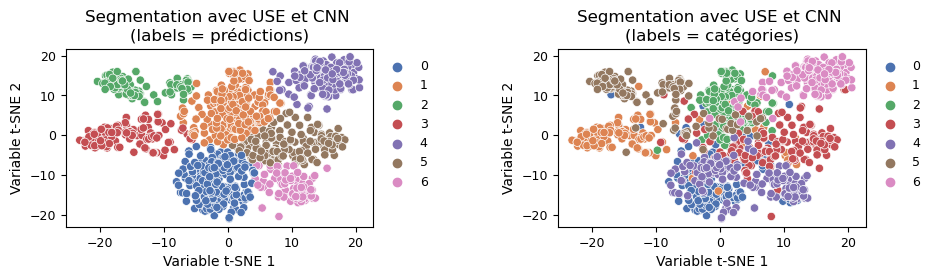

In [20]:
ARI_mixte_use, label_mixte_use = p6.graph_t_sne("USE et CNN", best_perp_mixte_use, 
                                                X_mixte_use, lab_category, n_clusters = 7)

<a class="anchor" id="section_1_4_1_3"></a>
#### Matrice de confusion

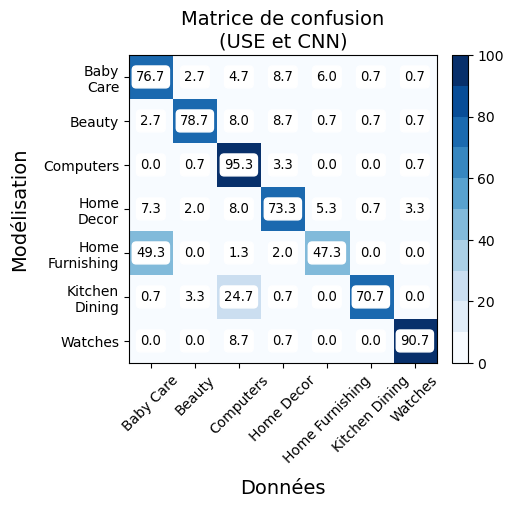

In [21]:
data["label_mixte_use"] = label_mixte_use

p6.graph_matrix(data["category_label"], data["label_mixte_use"], "USE et CNN")

<a class="anchor" id="section_1_4_2"></a>
### TF-IDF et CNN

<a class="anchor" id="section_1_4_2_1"></a>
#### Préparation du jeu de données

In [55]:
best_data_text_tfidf = pd.read_csv("data_tfidf_projet_6.csv", low_memory=False, index_col=0)

display(best_data_text_tfidf.shape)

(1050, 5001)

In [56]:
best_data_text_tfidf.iloc[:,:5].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1050 entries, 0 to 1049
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   1050 non-null   object 
 1   0       1050 non-null   float64
 2   1       1050 non-null   float64
 3   2       1050 non-null   float64
 4   3       1050 non-null   float64
dtypes: float64(4), object(1)
memory usage: 49.2+ KB


In [57]:
df_data_mixte_tfidf = pd.merge(best_data_text_tfidf, df_features_cnn, 
                               left_on="image", right_on="image", how="outer")
df_data_mixte_tfidf.shape

(1050, 9097)

In [58]:
df_data_mixte_tfidf.iloc[:,:5].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1050 entries, 0 to 1049
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   1050 non-null   object 
 1   0       1050 non-null   float64
 2   1       1050 non-null   float64
 3   2       1050 non-null   float64
 4   3       1050 non-null   float64
dtypes: float64(4), object(1)
memory usage: 49.2+ KB


In [59]:
X_mixte_tfidf = df_data_mixte_tfidf.iloc[:,1:].values

display((X_mixte_tfidf.shape))

(1050, 9096)

<a class="anchor" id="section_1_4_2_2"></a>
#### Visualisation t-SNE

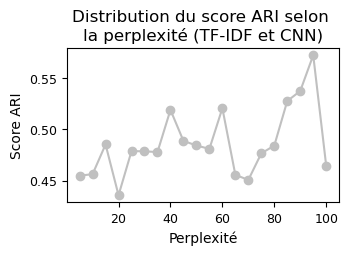

In [60]:
best_perp_mixte_tfidf = p6.best_perplexity(lab_category, X_mixte_tfidf, "TF-IDF et CNN", 
                                           perp_min = 5, perp_max = 105, step = 5, n_clusters = 7)

Pour le modèle TF-IDF et CNN, le score ARI est : 0.57236


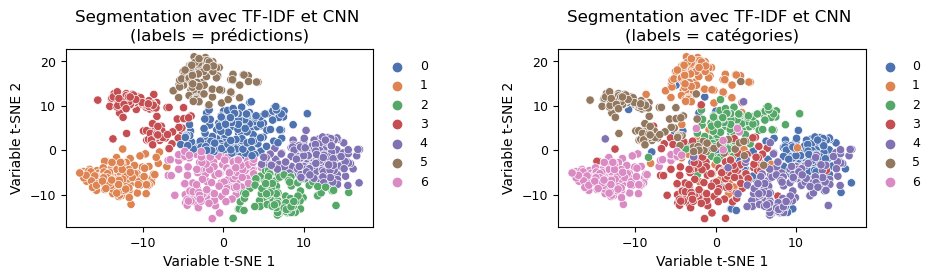

In [61]:
ARI_mixte_tfidf, label_mixte_tfidf = p6.graph_t_sne("TF-IDF et CNN", best_perp_mixte_tfidf,
                                                    X_mixte_tfidf, lab_category, n_clusters = 7)

<a class="anchor" id="section_1_4_2_3"></a>
#### Matrice de confusion

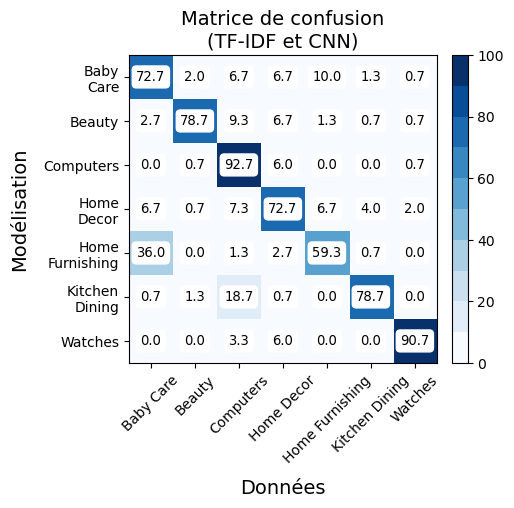

In [62]:
data["label_mixte_tfidf"] = label_mixte_tfidf

p6.graph_matrix(data["category_label"], data["label_mixte_tfidf"], "TF-IDF et CNN")

<a class="anchor" id="chapter2"></a>
# Chapitre 2 : Création de nouveaux modèles

<a class="anchor" id="section_2_1"></a>
## Création des modèles

<a class="anchor" id="section_2_1_1"></a>
### Modèle test 1

In [30]:
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, GlobalAveragePooling1D
from keras import Model
from keras.optimizers import Adam

model = VGG16()
model_test = Model(inputs=model.inputs, outputs=model.layers[-2].output)
        
x = model_test.output

predictions = Dense(7, activation='softmax')(x)

model_test_1 = Model(inputs=model_test.input, outputs=predictions)

for layer in model_test_1.layers[-1:]:
    layer.trainable = True
    
for layer in model_test_1.layers[:-1]:
    layer.trainable = False

model_test_1.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

display(model_test_1.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

None

<a class="anchor" id="section_2_1_2"></a>
### Modèle test 2

In [31]:
from tensorflow.keras.optimizers import SGD

model_test = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Classifier
x = model_test.output
x = Flatten()(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu', name='top-fc1')(x)
x = Dense(128, activation='relu', name='top-fc2')(x)
x = Dropout(0.1)(x)

# output layer: nombre de neurones de sortie = nombre de classe a prédire
output_layer = Dense(7, activation='softmax', name='softmax')(x)

# Assemblage du modèle final
model_test_2 = Model(inputs=model_test.input, outputs=output_layer)

# freeze de certains layers (spécifique au modèle utilisé)
for layer in model_test_2.layers[:-6]:
    layer.trainable = False
    
# Entrainement des derniers layers de classification
for layer in model_test_2.layers[-6:]:
    layer.trainable = True

# compilation du modele
model_test_2.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

print(model_test_2.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

<a class="anchor" id="section_2_2"></a>
## Jeu de données

<a class="anchor" id="section_2_2_1"></a>
### Séparation des données

In [32]:
liste_categ = data["Main_category"].unique()

display(liste_categ)

array(['Baby Care', 'Beauty and Personal Care', 'Computers',
       'Home Decor & Festive Needs', 'Home Furnishing',
       'Kitchen & Dining', 'Watches'], dtype=object)

In [33]:
import os
newpath = path
path_categ = []
for i in range (0, len(liste_categ)):
    path_d = os.path.join(path, liste_categ[i])
    display(path_d)
    path_categ.append(path_d)
    
    if not os.path.exists(path_d):
        os.mkdir(path_d)

'C:/Users/farid/Anaconda/Notebook/Dataset_p6/Baby Care'

'C:/Users/farid/Anaconda/Notebook/Dataset_p6/Beauty and Personal Care'

'C:/Users/farid/Anaconda/Notebook/Dataset_p6/Computers'

'C:/Users/farid/Anaconda/Notebook/Dataset_p6/Home Decor & Festive Needs'

'C:/Users/farid/Anaconda/Notebook/Dataset_p6/Home Furnishing'

'C:/Users/farid/Anaconda/Notebook/Dataset_p6/Kitchen & Dining'

'C:/Users/farid/Anaconda/Notebook/Dataset_p6/Watches'

In [34]:
for i in range (0, len(path_categ)) : 
    path_categ[i] = path_categ[i]+str("/")
    
liste_img = []
for i in range (0, len(liste_categ)):
    liste_img.append(data.loc[data["Main_category"]==liste_categ[i], "image"].values)

In [35]:
import shutil

# for i in range (0,7):
#     source_folder = path
#     destination_folder = path_categ[i]
    
#     for file_name in liste_img[i]:
        
#         source = source_folder + file_name
#         destination = destination_folder + file_name
        
#         if os.path.isfile(source):
#             shutil.copy(source, destination)

In [36]:
for i in range (0, len(liste_categ)):
    path_d = os.path.join(path, "Test")
    
    path_categ.append(path_d)
    
    if not os.path.exists(path_d):
        os.mkdir(path_d)

In [37]:
new_folder_test = ['C:/Users/farid/Anaconda/Notebook/Dataset_p6/Test/Baby Care/',
                   'C:/Users/farid/Anaconda/Notebook/Dataset_p6/Test/Beauty and Personal Care/',
                   'C:/Users/farid/Anaconda/Notebook/Dataset_p6/Test/Computers/',
                   'C:/Users/farid/Anaconda/Notebook/Dataset_p6/Test/Home Decor & Festive Needs/',
                   'C:/Users/farid/Anaconda/Notebook/Dataset_p6/Test/Home Furnishing/',
                   'C:/Users/farid/Anaconda/Notebook/Dataset_p6/Test/Kitchen & Dining/',
                   'C:/Users/farid/Anaconda/Notebook/Dataset_p6/Test/Watches/']

new_folder_train = ['C:/Users/farid/Anaconda/Notebook/Dataset_p6/Train/Baby Care/',
                    'C:/Users/farid/Anaconda/Notebook/Dataset_p6/Train/Beauty and Personal Care/',
                    'C:/Users/farid/Anaconda/Notebook/Dataset_p6/Train/Computers/',
                    'C:/Users/farid/Anaconda/Notebook/Dataset_p6/Train/Home Decor & Festive Needs/',
                    'C:/Users/farid/Anaconda/Notebook/Dataset_p6/Train/Home Furnishing/',
                    'C:/Users/farid/Anaconda/Notebook/Dataset_p6/Train/Kitchen & Dining/',
                    'C:/Users/farid/Anaconda/Notebook/Dataset_p6/Train/Watches/']

In [38]:
path_test = os.path.join(path, "Test")
path_train = os.path.join(path, "Train")
display(path_test)

'C:/Users/farid/Anaconda/Notebook/Dataset_p6/Test'

In [39]:
for i in range (0,7):
    folder = os.listdir(new_folder_test[i])
    for file in folder:
        data.loc[(data["image"]==file) & (data["Main_category"]==liste_categ[i]), "type_data"] = "Test"

data.loc[data["type_data"].isna(), "type_data"]="Train"        
display(data["type_data"].value_counts())

Train    784
Test     266
Name: type_data, dtype: int64

<a class="anchor" id="section_2_2_2"></a>
### Création des données d'entraînement et de validation

In [40]:
from tensorflow.keras.utils import to_categorical

X_train_raw = data.loc[data["type_data"]=="Train", ["image", "Main_category","type_data"]].reset_index(drop=True)  
y_train_raw = to_categorical(data.loc[data["type_data"]=="Train", "category_label"])

X_test = data.loc[data["type_data"]=="Test", ["image", "Main_category","type_data"]].reset_index(drop=True)
y_test = to_categorical(data.loc[data["type_data"]=="Test", "category_label"])

display(X_test.shape)

(266, 3)

In [41]:
prep_train = []

for i in range(0, X_train_raw.shape[0]):
    
    img = Image.open(path + X_train_raw.iloc[i]["image"])  # Charger l'image
    img = img.resize((224,224))
    img_array = np.array(img)
   
    img_reshape = img_array.reshape((img_array.shape[0], img_array.shape[1], img_array.shape[2]))
    img_prep = preprocess_input(img_reshape)
    
    prep_train.append(img_prep)
    prep_train_arr = np.array(prep_train)

In [42]:
prep_test = []

for i in range(0, X_test.shape[0]):
    
    img = Image.open(path + X_test.iloc[i]["image"])  # Charger l'image
    img = img.resize((224,224))
    img_array = np.array(img)
    img_reshape = img_array.reshape((img_array.shape[0], img_array.shape[1], img_array.shape[2]))
    img_prep = preprocess_input(img_reshape)
    
    prep_test.append(img_prep)
    prep_test_arr = np.array(prep_test)

C:\Users\farid\Anaconda\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [43]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(prep_train_arr, y_train_raw, 
                                                                  stratify = X_train_raw["Main_category"], 
                                                                  train_size=0.75, random_state=65)

display(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(588, 224, 224, 3)

(196, 224, 224, 3)

(588, 7)

(196, 7)

<a class="anchor" id="section_2_3"></a>
## Entraînement du modèle test 1

<a class="anchor" id="section_2_3_1"></a>
### Entraînement

In [44]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Création du callback
model_test_1_save_path = "./model_best_weights_test_1.h5"

checkpoint_1 = ModelCheckpoint(model_test_1_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

es_1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callbacks_list_1 = [checkpoint_1, es_1]

In [45]:
import tensorflow as tf
with tf.device('/gpu:0'): 
    history_test_1 = model_test_1.fit(X_train, y_train, epochs=200, batch_size=64,
                                      callbacks = callbacks_list_1, 
                                      validation_data = (X_val, y_val), 
                                      verbose=1)
    

Epoch 1/200
10/10 [==============================] - ETA: 0s - loss: 1.5498 - accuracy: 0.6190 
Epoch 1: val_loss improved from inf to 0.63237, saving model to .\model_best_weights_test_1.h5
10/10 [==============================] - 190s 19s/step - loss: 1.5498 - accuracy: 0.6190 - val_loss: 0.6324 - val_accuracy: 0.8163
Epoch 2/200
10/10 [==============================] - ETA: 0s - loss: 0.4956 - accuracy: 0.8537 
Epoch 2: val_loss did not improve from 0.63237
10/10 [==============================] - 182s 19s/step - loss: 0.4956 - accuracy: 0.8537 - val_loss: 0.7681 - val_accuracy: 0.7704
Epoch 3/200
10/10 [==============================] - ETA: 0s - loss: 0.2478 - accuracy: 0.9167 
Epoch 3: val_loss did not improve from 0.63237
10/10 [==============================] - 181s 18s/step - loss: 0.2478 - accuracy: 0.9167 - val_loss: 0.6644 - val_accuracy: 0.8316
Epoch 4/200
10/10 [==============================] - ETA: 0s - loss: 0.1881 - accuracy: 0.9337 
Epoch 4: val_loss did not improve 

<a class="anchor" id="section_2_3_2"></a>
### Fonction coût et score

In [46]:
loss_train_1, accuracy_train_1 = model_test_1.evaluate(X_train, y_train, verbose=True)
print(f"Score données d'entraînement : {round(accuracy_train_1,5)}")
print()

loss_val_1, accuracy_val_1 = model_test_1.evaluate(X_val, y_val, verbose=True)
print(f"Score données de validation :  {round(accuracy_val_1,5)}")

19/19 [==============================] - 137s 7s/step - loss: 0.0064 - accuracy: 1.0000
Score données d'entraînement : 1.0

7/7 [==============================] - 46s 6s/step - loss: 0.8349 - accuracy: 0.8316
Score données de validation :  0.83163


In [47]:
# Score de l'epoch optimal

model_test_1.load_weights(model_test_1_save_path)

loss_val_opti_1, accuracy_val_opti_1 = model_test_1.evaluate(X_val, y_val, verbose=False)
print(f"Score données de validation :  {round(accuracy_val_opti_1,5)}")

loss_test_opti_1, accuracy_test_opti_1 = model_test_1.evaluate(prep_test_arr, y_test, verbose=False)
print(f"Score données de test       :  {round(accuracy_test_opti_1,5)}")

Score données de validation :  0.81633
Score données de test       :  0.74812


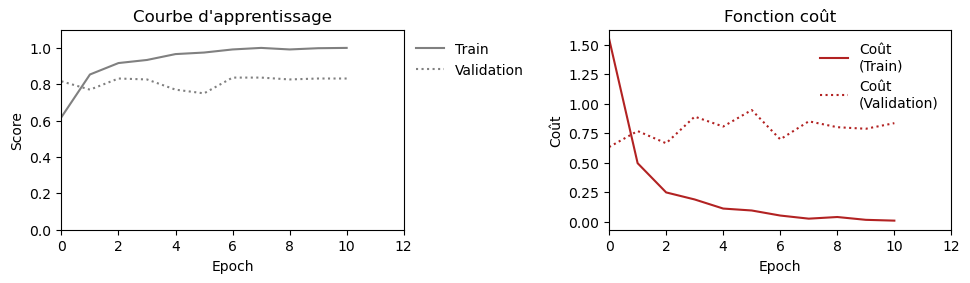

In [48]:
plt.figure(figsize=(10,2.5))

plt.subplot(121)

ep = len(history_test_1.history['accuracy'])

plt.plot(history_test_1.history['accuracy'], color = "gray", label = "Train")
plt.plot(history_test_1.history['val_accuracy'],  color = "gray", ls="dotted", label = "Validation")

plt.title("Courbe d'apprentissage")

plt.ylabel('Score')
plt.xlabel('Epoch')

plt.legend(frameon = False, bbox_to_anchor=(1,1))

plt.xlim(0, ep+1)
plt.ylim(0,1.1)

plt.subplot(122)

plt.plot(history_test_1.history['loss'],  color = "firebrick", label = "Coût\n(Train)")
plt.plot(history_test_1.history['val_loss'], color = "firebrick", ls="dotted", label = "Coût\n(Validation)")

plt.title('Fonction coût')

plt.ylabel('Coût')
plt.xlabel('Epoch')

plt.xlim(0,ep+1)
# plt.ylim(0,1)

plt.legend(frameon = False, bbox_to_anchor=(1,1))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.99, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.6)
plt.show() 

<a class="anchor" id="section_2_3_3"></a>
### Matrice de confusion

In [66]:
model_test_1.load_weights(model_test_1_save_path)

y_val_test_1_pred = np.argmax(model_test_1.predict(prep_test_arr), axis=1)
y_val_reelle = np.argmax(y_test, axis=1)

9/9 [==============================] - 62s 7s/step


In [67]:
ARI_test_1 = np.round(metrics.adjusted_rand_score(y_val_reelle, y_val_test_1_pred),5)

display(f"Le score ARI pour les données test est : {ARI_test_1}.")

'Le score ARI pour les données test est : 0.51995.'

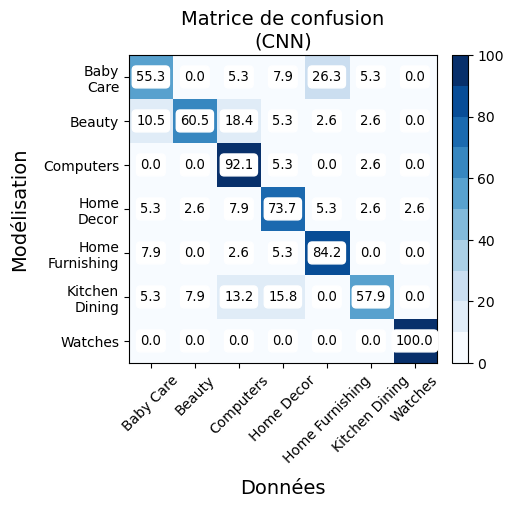

In [68]:
p6.graph_matrix(y_val_reelle, y_val_test_1_pred, "CNN")

<a class="anchor" id="section_2_4"></a>
## Entraînement du modèle test 2

<a class="anchor" id="section_2_4_1"></a>
### Entraînement

In [35]:
# Création du callback
model_test_2_save_path = "./model_best_weights_test_2.h5"

checkpoint_2 = ModelCheckpoint(model_test_2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

es_2 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callbacks_list_2 = [checkpoint_2, es_2]

In [36]:
import tensorflow as tf
with tf.device('/gpu:0'): 
    history_test_2 = model_test_2.fit(X_train, y_train, epochs=200, batch_size=64,
                                      callbacks = callbacks_list_2, 
                                      validation_data = (X_val, y_val), 
                                      verbose=1)    

Epoch 1/200
10/10 [==============================] - ETA: 0s - loss: 13.1505 - accuracy: 0.1667
Epoch 1: val_loss improved from inf to 8.11277, saving model to .\model_best_weights_test_2.h5
10/10 [==============================] - 45s 5s/step - loss: 13.1505 - accuracy: 0.1667 - val_loss: 8.1128 - val_accuracy: 0.2194
Epoch 2/200
10/10 [==============================] - ETA: 0s - loss: 7.7606 - accuracy: 0.2568
Epoch 2: val_loss improved from 8.11277 to 5.51460, saving model to .\model_best_weights_test_2.h5
10/10 [==============================] - 45s 5s/step - loss: 7.7606 - accuracy: 0.2568 - val_loss: 5.5146 - val_accuracy: 0.3061
Epoch 3/200
10/10 [==============================] - ETA: 0s - loss: 5.3603 - accuracy: 0.3605
Epoch 3: val_loss improved from 5.51460 to 4.29302, saving model to .\model_best_weights_test_2.h5
10/10 [==============================] - 45s 5s/step - loss: 5.3603 - accuracy: 0.3605 - val_loss: 4.2930 - val_accuracy: 0.3827
Epoch 4/200
10/10 [==============

Epoch 52/200
10/10 [==============================] - ETA: 0s - loss: 0.0734 - accuracy: 0.9813
Epoch 52: val_loss improved from 1.98532 to 1.98276, saving model to .\model_best_weights_test_2.h5
10/10 [==============================] - 100s 10s/step - loss: 0.0734 - accuracy: 0.9813 - val_loss: 1.9828 - val_accuracy: 0.7245
Epoch 53/200
10/10 [==============================] - ETA: 0s - loss: 0.0626 - accuracy: 0.9796
Epoch 53: val_loss did not improve from 1.98276
10/10 [==============================] - 96s 10s/step - loss: 0.0626 - accuracy: 0.9796 - val_loss: 1.9876 - val_accuracy: 0.7092
Epoch 54/200
10/10 [==============================] - ETA: 0s - loss: 0.0372 - accuracy: 0.9847
Epoch 54: val_loss did not improve from 1.98276
10/10 [==============================] - 96s 10s/step - loss: 0.0372 - accuracy: 0.9847 - val_loss: 1.9912 - val_accuracy: 0.7143
Epoch 55/200
10/10 [==============================] - ETA: 0s - loss: 0.0534 - accuracy: 0.9847
Epoch 55: val_loss did not im

10/10 [==============================] - 89s 9s/step - loss: 0.0378 - accuracy: 0.9847 - val_loss: 1.9720 - val_accuracy: 0.7398
Epoch 81/200
10/10 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9898
Epoch 81: val_loss did not improve from 1.95126
10/10 [==============================] - 90s 9s/step - loss: 0.0189 - accuracy: 0.9898 - val_loss: 1.9712 - val_accuracy: 0.7347
Epoch 82/200
10/10 [==============================] - ETA: 0s - loss: 0.0187 - accuracy: 0.9949
Epoch 82: val_loss did not improve from 1.95126
10/10 [==============================] - 91s 9s/step - loss: 0.0187 - accuracy: 0.9949 - val_loss: 1.9685 - val_accuracy: 0.7347
Epoch 83/200
10/10 [==============================] - ETA: 0s - loss: 0.0210 - accuracy: 0.9932
Epoch 83: val_loss did not improve from 1.95126
10/10 [==============================] - 88s 9s/step - loss: 0.0210 - accuracy: 0.9932 - val_loss: 1.9650 - val_accuracy: 0.7449
Epoch 84/200
10/10 [==============================] 

10/10 [==============================] - 66s 7s/step - loss: 0.0131 - accuracy: 0.9932 - val_loss: 1.8749 - val_accuracy: 0.7551
Epoch 108/200
10/10 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.9966
Epoch 108: val_loss did not improve from 1.87479
10/10 [==============================] - 66s 7s/step - loss: 0.0119 - accuracy: 0.9966 - val_loss: 1.8751 - val_accuracy: 0.7551
Epoch 109/200
10/10 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9932
Epoch 109: val_loss did not improve from 1.87479
10/10 [==============================] - 64s 7s/step - loss: 0.0207 - accuracy: 0.9932 - val_loss: 1.8772 - val_accuracy: 0.7551
Epoch 110/200
10/10 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9983
Epoch 110: val_loss did not improve from 1.87479
10/10 [==============================] - 64s 7s/step - loss: 0.0120 - accuracy: 0.9983 - val_loss: 1.8780 - val_accuracy: 0.7653
Epoch 111/200
10/10 [=========================

<a class="anchor" id="section_2_4_2"></a>
### Fonction coût et score

In [37]:
loss_train, accuracy_train = model_test_2.evaluate(X_train, y_train, verbose=True)
print(f"Score données de d'entraînement : {round(accuracy_train,5)}")
print()

loss_val, accuracy_val = model_test_2.evaluate(X_val, y_val, verbose=True)
print(f"Score données de validation : {round(accuracy_val,5)}")

19/19 [==============================] - 44s 2s/step - loss: 4.6971e-05 - accuracy: 1.0000
Score données de d'entraînement : 1.0

7/7 [==============================] - 15s 2s/step - loss: 1.8939 - accuracy: 0.7602
Score données de validation : 0.7602


In [38]:
# Score de l'epoch optimal

model_test_2.load_weights(model_test_2_save_path)

loss_val, accuracy_val = model_test_2.evaluate(X_val, y_val, verbose=False)
print(f"Score données de validation :  {round(accuracy_val,5)}")

loss_test, accuracy_test = model_test_2.evaluate(prep_test_arr, y_test, verbose=False)
print(f"Score données de test       :  {round(accuracy_test,5)}")

Score données de validation :  0.7551
Score données de test       :  0.71053


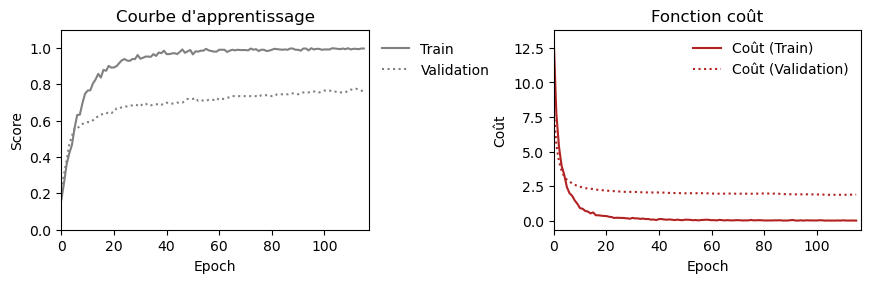

In [39]:
ep = len(history_test_2.history['accuracy'])

plt.figure(figsize=(10,2.5))

plt.subplot(121)

plt.plot(history_test_2.history['accuracy'], color = "gray", label = "Train")
plt.plot(history_test_2.history['val_accuracy'],  color = "gray", ls="dotted", label = "Validation")
plt.title("Courbe d'apprentissage")
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.legend(frameon = False, bbox_to_anchor=(1,1))

plt.xlim(0,ep+1)
plt.ylim(0,1.1)

plt.subplot(122)
plt.plot(history_test_2.history['loss'],  color = "firebrick", label = "Coût (Train)")
plt.plot(history_test_2.history['val_loss'], color = "firebrick", ls="dotted", label = "Coût (Validation)")
plt.title('Fonction coût')
plt.ylabel('Coût')
plt.xlabel('Epoch')

plt.xlim(0,ep+1)
# plt.ylim(0,1)

plt.legend(frameon = False, bbox_to_anchor=(1,1))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.6)
plt.show() 

<a class="anchor" id="section_2_4_3"></a>
### Matrice de confusion

In [40]:
y_val_test_2_pred = np.argmax(model_test_2.predict(prep_test_arr), axis=1)

9/9 [==============================] - 19s 2s/step


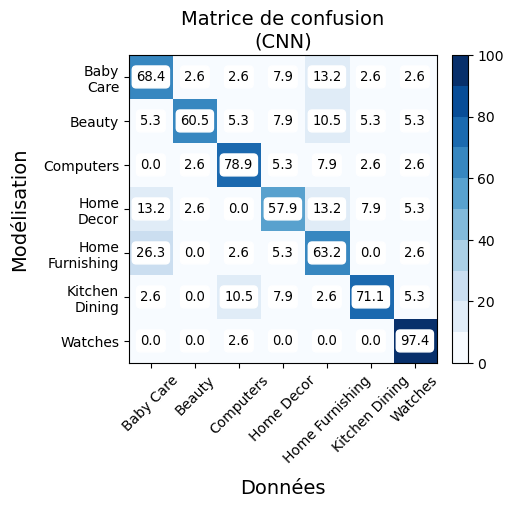

In [41]:
p6.graph_matrix(y_val_reelle, y_val_test_2_pred, "CNN")

In [42]:
ARI_test_2 = np.round(metrics.adjusted_rand_score(y_val_reelle, y_val_test_2_pred),5)

display(ARI_test_2)

0.57585

0.45268